# ECON281-Computation Homework 8

## Jung Hyun Kim

## Compute IRF to AR(1) productivity shocks in Krussel-Smith (1998) economy


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from blocks_jacobians import firm 

#pip install sequence-jacobian
from sequence_jacobian import grids, misc, interpolate
from sequence_jacobian.blocks.support.het_support import lottery_1d
from sequence_jacobian.utilities.solvers import newton_solver

### 0. Solve the steady state

In [2]:
# Variables
K = {'K'}
U = {'U'}
Y = {'A', 'Y', 'r', 'w'}

# parameters
eis = 1
delta = 0.025
alpha = 0.11
rho_e = 0.966
sd_e = 0.5
r = 0.01
Y = 1
L = 1.0
nE = 7
nA = 500
amin = 0
amax = 200
T = 100
calib = {'eis': eis, 'delta': delta, 'alpha': alpha, 'rho_e': rho_e, 'sd_e': sd_e, 'L': L, 'nE': nE, 'nA': nA, 'amin': amin, 'amax': amax}

# known steady state values
ss = {}
ss['r'] = r
ss['Y'] = Y
ss['L'] = L
ss['w'] = (1 - alpha) * ss['Y'] / ss['L']
ss['K'] = alpha * ss['Y'] / (ss['r'] + delta)
ss['A'] = ss['K']
ss['C'] = ss['Y'] - delta * ss['K']
ss['Z'] = ss['Y'] / (ss['K'] ** alpha * ss['L'] ** (1 - alpha))

# grids and initial conditions
e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
a_grid = grids.agrid(amin=amin, amax=amax, n=nA)


# analytical Jacobians from firm block
J = firm(calib, ss, T)

# define backward step
def backward_step(Va_p, Pi, a_grid, e_grid, r, w, beta, eis):
    uc_nextgrid = beta * (Pi @ Va_p)
    c_nextgrid = uc_nextgrid ** (-eis)
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    a = interpolate.interpolate_y(c_nextgrid + a_grid, coh, a_grid)
    misc.setmin(a, a_grid[0])
    c = coh - a
    Va = (1 + r) * c ** (-1 / eis)
    return Va, a, c

# steady state solver
def solve_steady_state_policy(Va0, Pi, a_grid, e_grid, r, w, beta, eis):
    Va = Va0
    for n in range(10000):
        Va, a, c = backward_step(Va, Pi, a_grid, e_grid, r, w, beta, eis)
        if np.max(np.abs(Va - Va0)) < 1e-8:
            print(f'Converged after {n} iterations')
            break
        Va0 = Va
    return Va, a, c

# computes the transition matrix based on policy function for assets
def compute_transition_matrix(a, a_grid, e_grid, Pi):
    nE = e_grid.shape[0]
    nA = a_grid.shape[0]

    # deterministic lottery allocation
    lottery = lottery_1d(a, a_grid, monotonic=False)

    # transition matrix built from lottery
    Lambda = np.zeros((nE, nA, nE, nA))
    for i in range(nE):
        for j in range(nA):
            Lambda[i, j, :, lottery.i[i, j]] = Pi[i, :] * lottery.pi[i, j]
            Lambda[i, j, :, lottery.i[i, j] + 1] = Pi[i, :] * (1 - lottery.pi[i, j])

    # matrix form to compute transition matrix
    Lambda = Lambda.reshape(nA * nE, nA * nE)

    return Lambda

# iterates on the distribution until convergence
def compute_steady_state_distribution(a, a_grid, e_grid, Pi):

    Lambda = compute_transition_matrix(a, a_grid, e_grid, Pi)

    nE = e_grid.shape[0]
    nA = a_grid.shape[0]

    D = np.ones(nE * nA) / (nE * nA)
    for n in range(10000):
        D = Lambda.T @ D
        if np.max(np.abs(D - D @ Lambda)) < 1e-8:
            D = D.reshape(nE, nA)
            print(f'Converged after {n} iterations')
            break
    return D, Lambda


In [3]:
# solve for beta such that asset demand is at steady state
coh = (1 + r) * a_grid[np.newaxis, :] + ss['w'] * e_grid[:, np.newaxis]
Va0 = (1 + r) * (0.1 * coh) ** (-1 / eis)

beta = 0.981
Va, a, c = solve_steady_state_policy(Va0, Pi, a_grid, e_grid, ss['r'], ss['w'], beta, eis)
D, Lambda = compute_steady_state_distribution(a, a_grid, e_grid, Pi)

# find beta that solves the market clearing problem in steady state
def objective(beta):
    Va, a, c = solve_steady_state_policy(Va0, Pi, a_grid, e_grid, ss['r'], ss['w'], beta, eis)
    D, Lambda = compute_steady_state_distribution(a, a_grid, e_grid, Pi)
    A = np.sum(D @ a_grid)
    return np.array([A - ss['A']])

beta, feval = newton_solver(objective, np.array([beta]))

print(beta)

calib['beta'] = beta

Va, a, c = solve_steady_state_policy(Va0, Pi, a_grid, e_grid, ss['r'], ss['w'], calib['beta'], eis)
D, Lambda = compute_steady_state_distribution(a, a_grid, e_grid, Pi)

ss['Va'] = Va
ss['a'] = a
ss['c'] = c
ss['D'] = D
ss['Lambda'] = Lambda


Converged after 361 iterations
Converged after 513 iterations
Converged after 361 iterations
Converged after 513 iterations
On iteration 0
x = 0.981
y = -0.554


Converged after 362 iterations
Converged after 513 iterations
Converged after 391 iterations
Converged after 568 iterations
On iteration 1
x = 0.982
y = 0.080


Converged after 391 iterations
Converged after 569 iterations
Converged after 387 iterations
Converged after 561 iterations
On iteration 2
x = 0.982
y = 0.001


Converged after 388 iterations
Converged after 562 iterations
Converged after 387 iterations
Converged after 561 iterations
On iteration 3
x = 0.982
y = 0.000


Converged after 388 iterations
Converged after 562 iterations
Converged after 387 iterations
Converged after 561 iterations
On iteration 4
x = 0.982
y = 0.000


Converged after 388 iterations
Converged after 562 iterations
Converged after 387 iterations
Converged after 561 iterations
On iteration 5
x = 0.982
y = 0.000


[0.98195277]
Converged after 387 

### 1. Compute Backward Step Once

- Calculate $y_0^s$ (aggregate asset demand) and $\Lambda_0^s$ (transition matrix between states at time $0$ given shock at time $s$) for each $s$ using single backward iteration from time $T-1$. 
- Lemma 1 of Auclert et al (2021): individual policy function and transition matrix depends on the distance to the shocks
- Only single perturbation of input at date $s=T-1$ suffices to get $y_t^s$ and $\Lambda_t^s$

In [4]:
# define r sequence 
dx = 1e-4
dA_seq = np.zeros(T,)
dr_seq = np.zeros(T + 1,)
dr_seq[T] = dx
a = np.zeros((nE, nA, T + 1))

# solve backward step starting at T + 1
Va_p = ss['Va']
a_seq = np.zeros((nE, nA, T + 1))
for t in range(T, -1, -1):
    Va_p, a_seq[:, :, t], c = backward_step(Va_p, Pi, a_grid, e_grid, ss['r'] + dr_seq[t], ss['w'], calib['beta'], eis)
    

### 2. Compute the first row of the Jacobian / Fake News Matrix (FNM)

The FNM $\mathcal{F}$ is defined as: 
$$
\mathcal{F}_{t,s} \cdot dx \equiv
\begin{cases}
dY_0^s & t = 0 \\
\mathcal{E}'_{t-1} d\mathbf{D}_1^s & t \geq 1
\end{cases} \\~\\

\text{where } dY_0^s = (dy_0^s) D_{ss} \text{ and } d\mathbf{D}_1^s = (d\mathbf{\Lambda}_0^s)' D_{ss}.
$$


- Each column of the first row of the Fake News Matrix $dY_0^s / dx$ represents time 0 response to the fake news shock at time $s$
- $dY_0^s = (d \mathbf{y}_0^s)'\mathbf{D}_{ss}$ represents the effect on output (Aggregate asset demand) from the shock to the input ($r$) at date $s$
- By symmetry of the policy function with respect to time, we have $\mathbf{y}_0^s = \mathbf{y}_{T-1-s}^{T-1} $

In [5]:
# Initialize FNM
F = np.zeros((T,T))
da = a_seq - ss['a'][:, :, np.newaxis] # Change in asset policy given shock at T-1

for s in range(T):
    F[0, s] = np.vdot(ss['D'], da[:,:,T-1-s]) / dx 


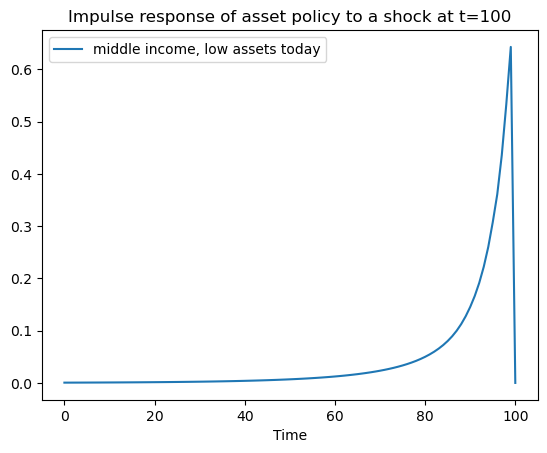

In [6]:
# plor IRF of asset policy to a shock at T-1
impulse_a = da/dx 

plt.figure()
plt.plot(impulse_a[3,0,:], label='middle income, low assets today')
plt.xlabel('Time')
plt.title('Impulse response of asset policy to a shock at t=100')
plt.legend()
plt.show()

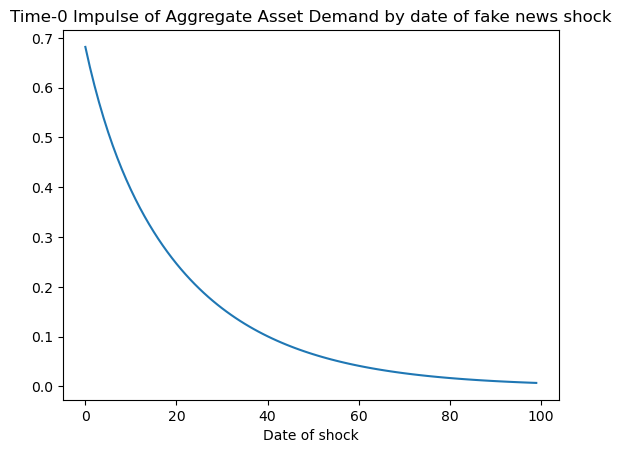

In [7]:
# plor IRF of Assets
plt.figure()
plt.plot(F[0, :])
plt.xlabel('Date of shock')
plt.title('Time-0 Impulse of Aggregate Asset Demand by date of fake news shock')
plt.show()

### 3. Compute $dD_1^s$ using steady state distribution and $s=0,...,T$ policy functions

- $d\mathbf{D}_1^s = (d\mathbf{\Lambda}_0^s)' D_{ss}$ is the response of the distribution at date 1 to shock at time $s$
- By symmetry of the transition matrix with respect to time, we have $\Lambda_0^s = \Lambda_{T-1-s}^{T-1}$

In [8]:
%%time 
dD1 = np.zeros((nE, nA, T), dtype=np.float32)
for s in range(T):
    dLambda0 = compute_transition_matrix(a_seq[:,:,T-1-s], a_grid, e_grid, Pi) - ss['Lambda']
    dD1[:,:,s] =  (dLambda0.T @ ss['D'].ravel()).reshape(nE, nA)


CPU times: total: 50 s
Wall time: 13.1 s


### 4. Compose the fake news matrix

The expectation vector for outcome $Y$ at time $t$ is defined as: 
$$
\mathcal{E}_t \equiv (\Lambda_{ss})^t \mathbf{y}_{ss}
$$
- $\mathcal{E}_t$ represents the expected time path for outcome $Y$ in the steady state for a given grid point
- By Lemma 3 of Auclert et al. (2021), $\mathcal{E}_t = \Lambda_{ss} \mathcal{E}_{t-1}$ with $\mathcal{E}_0 = \mathbf{y}_{ss}$

In [9]:
# Construct expectation vector
expvec = np.zeros((nE, nA, T))
expvec[:,:,0] = ss['a']
for t in range(1,T): 
    expvec[:,:,t] = (ss['Lambda'] @ expvec[:,:,t-1].ravel()).reshape(nE, nA)

# Construct the FNM
for t in range(1,T): 
    F[t,:] = expvec[:,:,t-1].ravel().T @ dD1.reshape(nE*nA, T) / dx

### 5. Compose the Jacobian using the fake news matrix

In [10]:
J['HA'] = {'A': F.copy(), 
           'Z': np.zeros((T,T))}

for t in range(1, F.shape[0]):
    J['HA']['A'][1:, t] += J['HA']['A'][:-1, t-1]

### 6. Combine matrices to get $H_K$ and $H_Z$

$$ 
\begin{align*}
[\mathbf{H}_K]_{t,s} &= \frac{\partial \mathbf{A}_t}{\partial r_{s+1}} \frac{\partial r_{s+1}}{\partial K_s} + \frac{\partial \mathbf{A}_t}{\partial w_{s+1}} \frac{\partial w_{s+1}}{\partial K_s} - \mathbb{1}_{\{s=t\}} \\
[\mathbf{H}_Z]_{t,s} &= \frac{\partial \mathbf{A}_t}{\partial r_{s}} \frac{\partial r_{s}}{\partial Z_s} + \frac{\partial \mathbf{A}_t}{\partial w_{s}} \frac{\partial w_{s}}{\partial Z_s} - \mathbb{1}_{\{s=t\}} \\~\\

\therefore [\mathbf{H}_K]_{t,s} &= \frac{\partial \mathbf{A}_t}{\partial r_{s+1}} \left( \frac{\partial r_{s+1}}{\partial K_s} + \frac{\partial r_{s+1}}{\partial w_{s+1}}  \frac{\partial w_{s+1}}{\partial K_s} \right) - \mathbb{1}_{\{s=t\}} \\
[\mathbf{H}_Z]_{t,s} &= \frac{\partial \mathbf{A}_t}{\partial r_{s}} \left( \frac{\partial r_{s}}{\partial Z_s} + \frac{\partial r_{s}}{\partial w_{s}}  \frac{\partial w_{s}}{\partial Z_s} \right) - \mathbb{1}_{\{s=t\}} 
\end{align*}
$$

where we have: 
$$
\begin{align*}
\frac{\partial r_{s+1}}{\partial K_{s}} &= \alpha (\alpha - 1) Z_{ss} \left( \frac{K_{ss}}{L_{ss}} \right)^{\alpha-2} \frac{1}{L_{ss}} \\
\frac{\partial w_{s+1}}{\partial K_{s}} &= \alpha (1 - \alpha) Z_{ss} \left( \frac{K_{ss}}{L_{ss}} \right)^{\alpha-1} \frac{1}{L_{ss}} \\
\frac{\partial r_s}{\partial w_s} &= -(1-\alpha)^{2-\alpha} Z_{ss}^{\frac{1}{\alpha}} w_{ss}^{-\frac{1}{\alpha}} \\
\frac{\partial r_{s}}{\partial Z_s} &= \alpha \left( \frac{K^{ss}}{L^{ss}} \right)^{\alpha-1} \\
\frac{\partial w_{s}}{\partial Z_s} &= (1-\alpha) \left( \frac{K^{ss}}{L^{ss}} \right)^{\alpha}
\end{align*}
$$

In [11]:
I = sp.sparse.eye(T)
drdK = alpha * (alpha-1) * ss['Z'] * (ss['K'] / ss['L'])**(alpha-2) * (1/ss['L'])
dwdK = alpha * (1-alpha) * ss['Z'] * (ss['K'] / ss['L'])**(alpha-1) * (1/ss['L'])
drdw = - (1-alpha)**(2-alpha) * ss['Z']**(1/alpha) * ss['w']**(-1/alpha)
drdZ = alpha * (ss['K']/ss['L'])**(alpha-1)
dwdZ = (1-alpha) * (ss['K']/ss['L'])**(alpha)


dHdK = np.hstack((J['HA']['A'][:, 1:] , np.zeros((T,1))))*(drdK + drdw*dwdK) - I 
dHdZ = J['HA']['A']*(drdZ + drdw*dwdZ) - I 

dKdZ = -sp.sparse.linalg.spsolve(dHdK, dHdZ)


d:\Anaconda\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format


### 7. Compute IRF to AR(1) productivity shocks with $\rho_a=0.9$ at $t=0$, $t=10$ 

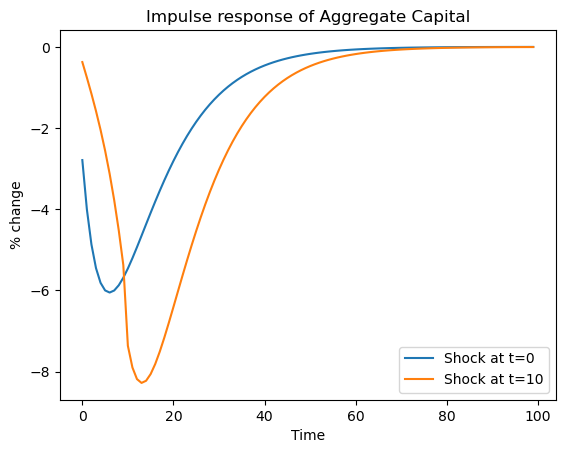

In [12]:
# AR(1) shock at t=0 and t=10
rho = 0.9

z0 = np.zeros(T)
z10 = np.zeros(T)

z0[0] = 1
z10[10] = 1

for i in range(1, T):
    z0[i] = rho * z0[i-1] 

for i in range(11, T): 
    z10[i] = rho * z10[i-1]


K0 = dKdZ @ z0 
K10 = dKdZ @ z10 

# Plot k and z 
plt.plot(K0, label='Shock at t=0')
plt.plot(K10, label='Shock at t=10')
plt.xlabel('Time')
plt.ylabel('% change')
plt.title('Impulse response of Aggregate Capital')
plt.legend()
plt.show()